In [1]:
# !pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d msambare/fer2013
! unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

# **IMPORT EVERYTHING HERE**

In [2]:
import os
import imghdr
import cv2 as cv
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


import tensorflow
from tensorflow.keras import layers, models, regularizers, optimizers

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

C:\Users\91770\AppData\Local\Temp\ipykernel_14696\3704250762.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


ModuleNotFoundError: No module named 'seaborn'

CHECK THE FORMAT OF THE IMAGE


In [3]:
def checkFileFormat( dataType ):
  ''' This function checks if  the image file is of format other than jpg, jpeg and png. If it is, we intend
       to remove from the data. '''


  dir = "/content/" + dataType

  for root , subdir , img_files in os.walk( dir ):
    for file in img_files :
      file_path = os.path.join( root , file )
      file_type = imghdr.what( file_path )
      if file_type not in [ 'jpg' , 'jpeg', 'png' ]:
        os.remove( file_path )
      else:
        img = cv.imread( file_path , 0 )
        #print( img.shape )


checkFileFormat( 'train' )
checkFileFormat( 'test' )

COUNT IMAGES IN EACH CATEGORY

In [4]:
def countImg( dataset , name ):
  ''' This function finds out the no. of images of each emotion in Training and Test Dataset '''

  D =  {}
  for subdir in os.listdir( dataset ):
    D[subdir] = len( os.listdir( os.path.join( dataset , subdir  ) ) )
    df = pd.DataFrame( D , index = [name] )

  return df

train_dir = "/content/train"
test_dir = "/content/test"

train_count = countImg( train_dir , "Train" )
print( train_count )

test_count = countImg( test_dir , "Test" )
print( test_count )

       surprise   sad  fear  neutral  happy  disgust  angry
Train      3171  4830  4097     4965   7215      436   3995
      surprise   sad  fear  neutral  happy  disgust  angry
Test       831  1247  1024     1233   1774      111    958


PLOT ALL THE CATEGORIES IN TEST AND TRAIN DATA

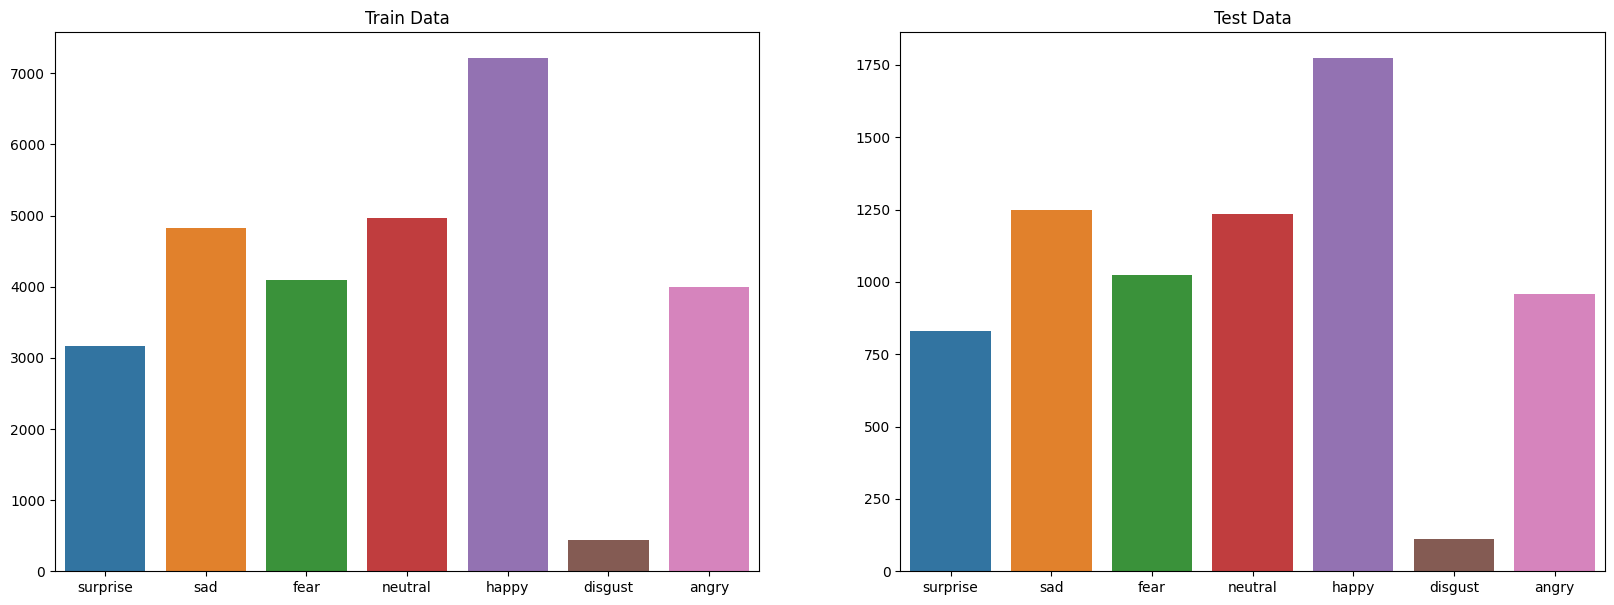

In [5]:
fig  , axes = plt.subplots( 1,2, figsize = (20,7) )
plt.subplot( 1,2,1)
sns.barplot( train_count )
plt.title( "Train Data" )

plt.subplot( 1,2,2)
sns.barplot( test_count )
plt.title( "Test Data" );

PRINT N IMAGE FROM EACH CATEGORY

# **CNN MODEL 1**

In [1]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

In [8]:
# Normal Data Generator method
#data_gen = ImageDataGenerator( rescale = 1./255 , validation_split = 0.25)

#Data Generator with Image Augumentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.20
)

train_gen = data_gen.flow_from_directory(
    train_dir ,
    target_size = ( img_width , img_height ) ,
    color_mode = 'grayscale' ,
    class_mode = 'categorical',
    batch_size = batch_size ,
    subset = 'training'
    )

val_gen = data_gen.flow_from_directory(
    train_dir ,
    target_size = ( img_width , img_height ) ,
    color_mode = 'grayscale' ,
    class_mode = 'categorical',
    batch_size = batch_size ,
    subset = 'validation'
    )

test_gen = data_gen.flow_from_directory(
    test_dir ,
    target_size = ( img_width , img_height ) ,
    color_mode = 'grayscale' ,
    class_mode = 'categorical',
    batch_size = batch_size
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
print( "Train Data Indices : " , train_gen.class_indices )
print( "Validation Data Indices : " , val_gen.class_indices )
print( "Test Data Indices : " , test_gen.class_indices )

Train Data Indices :  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation Data Indices :  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test Data Indices :  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [14]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [15]:
model.summary();

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_9 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                 

In [30]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
plot_model(model, to_file = '/content/Model_Architecture.png',
           show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
cnn_path = '/content/MODEL'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/MODEL/Custom_CNN_model.keras'

In [18]:

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [19]:
train_steps_per_epoch = train_gen.samples // train_gen.batch_size + 1
validation_steps_epoch = val_gen.samples // val_gen.batch_size + 1
test_steps_epoch = test_gen.samples // test_gen.batch_size + 1
steps_for_epochs = test_steps_epoch

print( "Steps for epochs : " , train_gen.samples )
print( "train_steps_per_epoch: " , train_steps_per_epoch  )
print( "validation_steps_epoch: " , validation_steps_epoch )
print( "test_steps_epoch: " , test_steps_epoch )


Steps for epochs :  22968
train_steps_per_epoch:  359
validation_steps_epoch:  90
test_steps_epoch:  113


In [20]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=25,
    validation_data=val_gen,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/25
359/359 [==============================] - ETA: 0s - loss: 12.4763 - accuracy: 0.2214
Epoch 1: val_loss improved from inf to 11.76398, saving model to /content/MODEL/Custom_CNN_model.keras
359/359 [==============================] - 156s 429ms/step - loss: 12.4763 - accuracy: 0.2214 - val_loss: 11.7640 - val_accuracy: 0.1601 - lr: 1.0000e-04
Epoch 2/25
359/359 [==============================] - ETA: 0s - loss: 10.2535 - accuracy: 0.2387
Epoch 2: val_loss improved from 11.76398 to 9.51018, saving model to /content/MODEL/Custom_CNN_model.keras
359/359 [==============================] - 152s 422ms/step - loss: 10.2535 - accuracy: 0.2387 - val_loss: 9.5102 - val_accuracy: 0.2451 - lr: 1.0000e-04
Epoch 3/25
359/359 [==============================] - ETA: 0s - loss: 8.1536 - accuracy: 0.2456
Epoch 3: val_loss improved from 9.51018 to 7.39728, saving model to /content/MODEL/Custom_CNN_model.keras
359/359 [==============================] - 152s 424ms/step - loss: 8.1536 - accuracy: 0

In [21]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))


    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

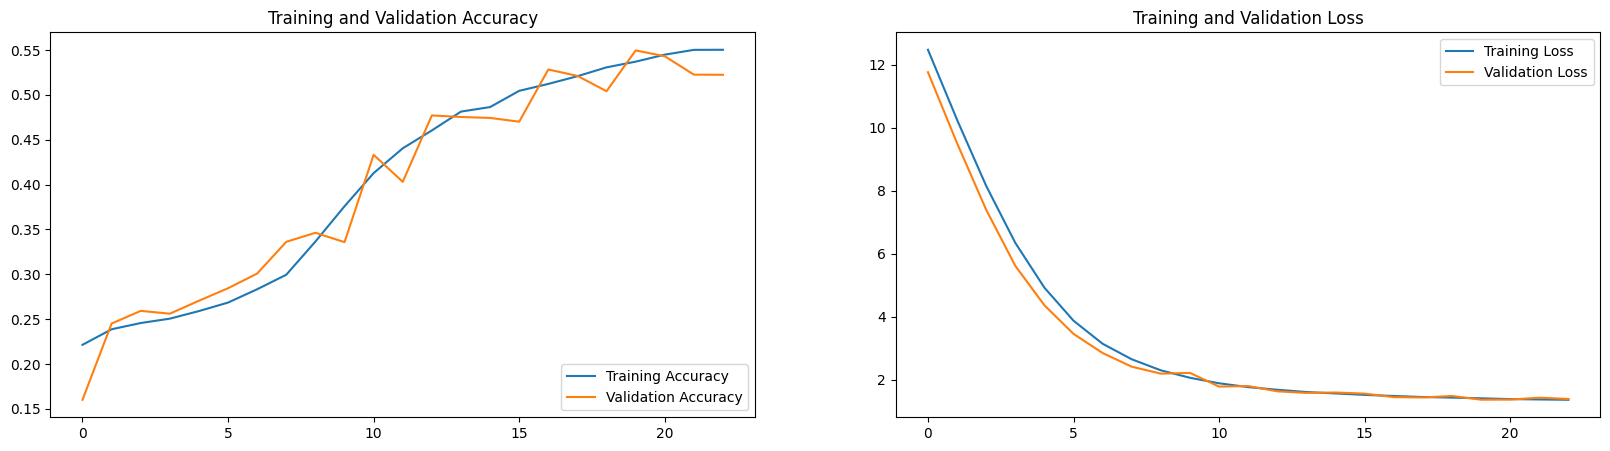

In [22]:
plot_training_history(history)

In [23]:
train_loss, train_accu = model.evaluate(train_gen)
test_loss, test_accu = model.evaluate(test_gen)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 7s 64ms/step - loss: 1.3694 - accuracy: 0.5435
final train accuracy = 55.86 , validation accuracy = 54.35


113/113 [==============================] - 7s 64ms/step


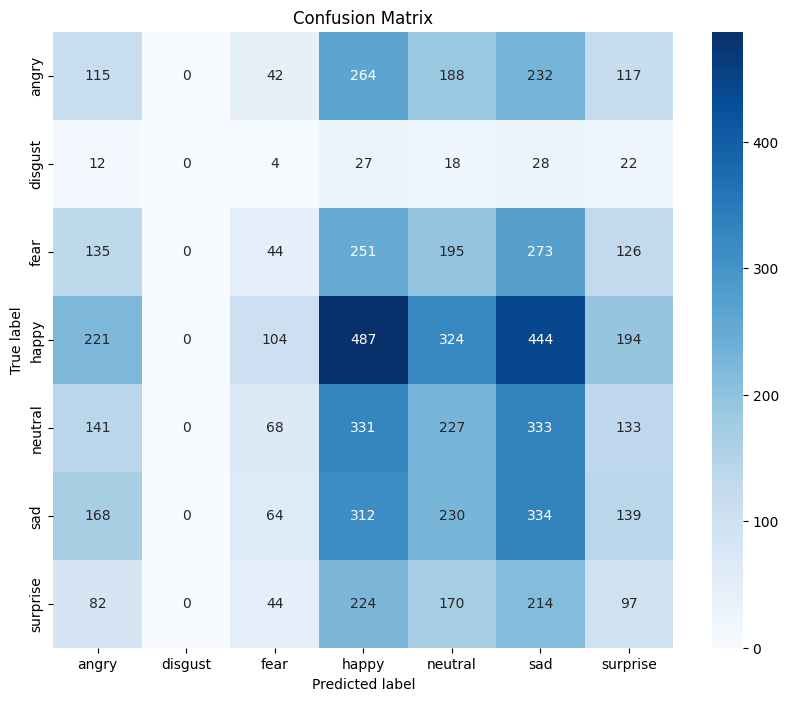

In [24]:

true_classes = test_gen.classes
predicted_classes = np.argmax(model.predict(test_gen, steps=np.ceil(test_gen.samples/test_gen.batch_size)), axis=1)
class_labels = list(test_gen.class_indices.keys())


cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.12      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.12      0.04      0.06      1024
       happy       0.26      0.27      0.27      1774
     neutral       0.17      0.18      0.18      1233
         sad       0.18      0.27      0.22      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


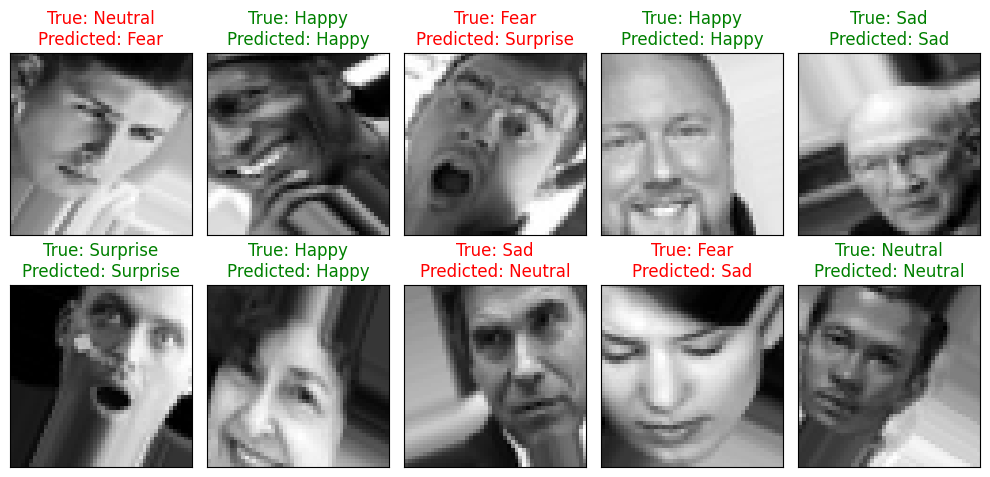

In [26]:

Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


batch_size = test_gen.batch_size


Random_batch = np.random.randint(0, len(test_gen) - 1)


Random_Img_Index = np.random.randint(0, batch_size, 10)


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_gen[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_gen[Random_batch][1][Random_Img_Index[i]], axis=0)


    Model_Prediction = np.argmax(model.predict(tensorflow.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(Random_Img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [31]:
model.save_weights('model.h5')